Data root: data\hdf5_data_final
CSV: data\t15_copyTaskData_description.csv
Sessions found: 45
- t15.2023.08.11 (1 files)
    • data_train.hdf5
- t15.2023.08.13 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.08.18 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.08.20 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.08.25 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.08.27 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.09.01 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.09.03 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.09.24 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.09.29 (3 files)
    • data_test.hdf5
    • data_train.hdf5
    • data_val.hdf5
- t15.2023.10.01 (3 files)
    • data_test.hdf5

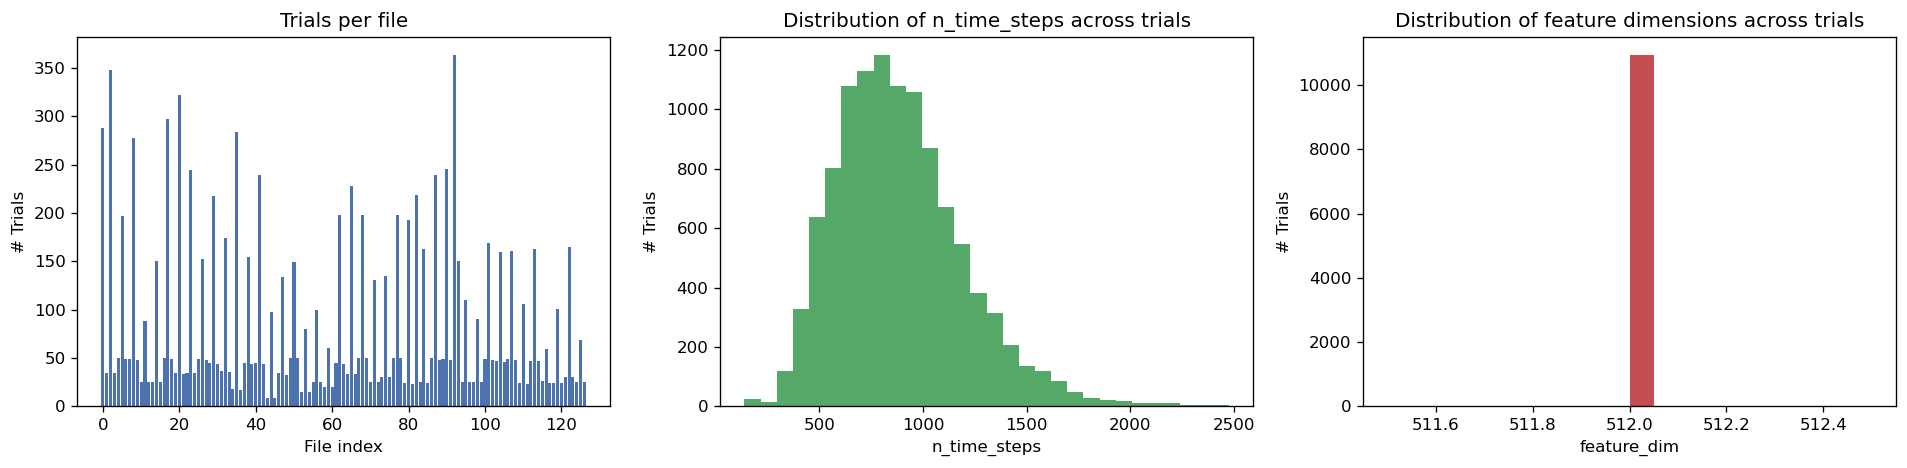


Loading example trial from: data_train.hdf5 | key: trial_0000


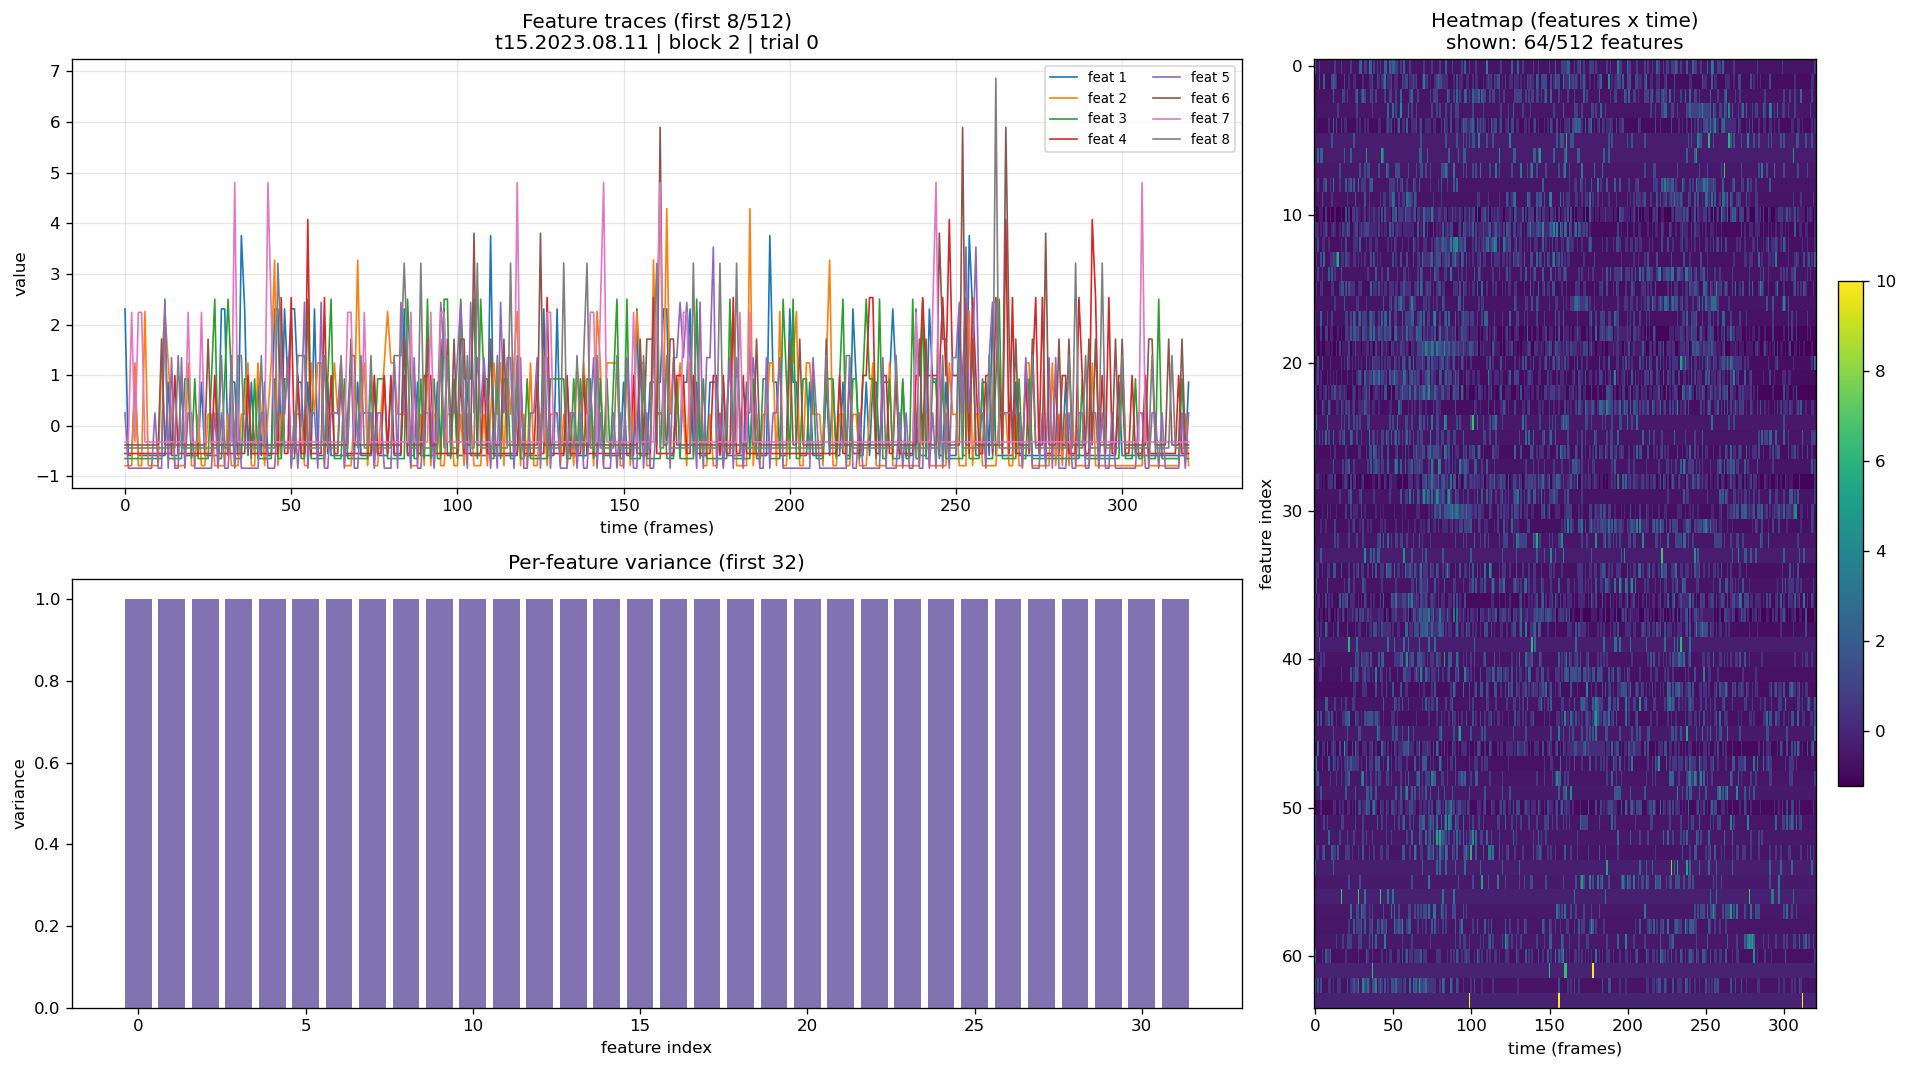

--- Trial metadata ---
session: t15.2023.08.11
block_num: 2
trial_num: 0
n_time_steps: 321
seq_len: 14
corpus: 50-Word
sentence_label: Bring it closer.
transcription: Bring it closer.


In [1]:
# HDF5 neuroactivity explorer for t15 copy task
# - Scans data/hdf5_data_final
# - Summarizes structure (sessions, files, trials, attributes)
# - Visualizes representative neural activity and global distributions

import os
from pathlib import Path
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

plt.rcParams["figure.dpi"] = 120

# -------------------------
# Paths (robust to notebook cwd)
# -------------------------

def resolve_path(primary: str, fallback: str) -> Path:
    p = Path(primary)
    return p if p.exists() else Path(fallback)

DATA_DIR = resolve_path('../data/hdf5_data_final', 'data/hdf5_data_final')
CSV_PATH = resolve_path('../data/t15_copyTaskData_description.csv', 'data/t15_copyTaskData_description.csv')

assert DATA_DIR.exists(), f"Data directory not found: {DATA_DIR}"
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"

b2txt_csv_df = pd.read_csv(CSV_PATH)

# -------------------------
# Utilities
# -------------------------

def safe_decode(x):
    if x is None:
        return None
    if isinstance(x, (bytes, bytearray)):
        try:
            return x.decode('utf-8')
        except Exception:
            return str(x)
    if isinstance(x, np.ndarray):
        # Could be array of ints or bytes; try to interpret
        if x.dtype.kind in {'i', 'u'}:
            # Treat as ASCII/int-coded with zero-termination
            zero_idx = np.where(x == 0)[0]
            end = zero_idx[0] if len(zero_idx) > 0 else len(x)
            return ''.join(chr(int(c)) for c in x[:end])
        if x.dtype.kind in {'S', 'U', 'O'}:
            # Byte string array, take first element
            try:
                return x.tobytes().decode('utf-8', errors='ignore')
            except Exception:
                try:
                    return x.astype(str).item()
                except Exception:
                    return str(x)
    return str(x)


def list_hdf5_files(data_root: Path):
    sessions = sorted([p for p in data_root.iterdir() if p.is_dir()])
    files = []
    for session_dir in sessions:
        for fname in sorted(session_dir.glob('*.hdf5')):
            files.append((session_dir.name, fname))
    return files


def summarize_h5_file(h5_path: Path):
    summary = {
        'path': str(h5_path),
        'num_trials': 0,
        'trial_keys': [],
        'n_time_steps': [],
        'feature_dims': [],
        'blocks': [],
        'sessions': [],
        'trial_nums': [],
        'seq_lens': [],
    }
    with h5py.File(h5_path, 'r') as f:
        for key in f.keys():
            g = f[key]
            # Required dataset
            if 'input_features' not in g:
                continue
            ds = g['input_features']
            t_len = g.attrs.get('n_time_steps', ds.shape[0])
            feat_dim = ds.shape[1] if ds.ndim >= 2 else 1
            summary['num_trials'] += 1
            summary['trial_keys'].append(key)
            summary['n_time_steps'].append(int(t_len))
            summary['feature_dims'].append(int(feat_dim))
            summary['blocks'].append(int(g.attrs.get('block_num', -1)))
            session_attr = g.attrs.get('session', '')
            if isinstance(session_attr, (bytes, bytearray)):
                session_attr = session_attr.decode('utf-8', errors='ignore')
            summary['sessions'].append(session_attr)
            summary['trial_nums'].append(int(g.attrs.get('trial_num', -1)))
            if 'seq_len' in g.attrs:
                summary['seq_lens'].append(int(g.attrs['seq_len']))
            else:
                summary['seq_lens'].append(None)
    return summary


def print_dataset_tree(files):
    print(f"Data root: {DATA_DIR}")
    print(f"CSV: {CSV_PATH}")
    print(f"Sessions found: {len(sorted({s for s, _ in files}))}")
    by_session = defaultdict(list)
    for session, fpath in files:
        by_session[session].append(fpath)
    for session in sorted(by_session.keys()):
        print(f"- {session} ({len(by_session[session])} files)")
        for fpath in by_session[session]:
            print(f"    • {fpath.name}")


def match_corpus_from_csv(session_str: str, block_num: int):
    # session like 't15.2023.08.11' → date '2023-08-11'
    try:
        parts = session_str.split('.')
        date = f"{parts[1]}-{parts[2]}-{parts[3]}"
    except Exception:
        return None
    m = b2txt_csv_df[(b2txt_csv_df['Date'] == date) & (b2txt_csv_df['Block number'] == block_num)]
    if len(m) == 0:
        return None
    return m['Corpus'].values[0]


def load_example_trial(h5_path: Path, trial_key: str):
    with h5py.File(h5_path, 'r') as f:
        g = f[trial_key]
        feats = g['input_features'][:]
        meta = {
            'n_time_steps': int(g.attrs.get('n_time_steps', feats.shape[0])),
            'seq_len': int(g.attrs['seq_len']) if 'seq_len' in g.attrs else None,
            'session': g.attrs.get('session', ''),
            'block_num': int(g.attrs.get('block_num', -1)),
            'trial_num': int(g.attrs.get('trial_num', -1)),
            'sentence_label': safe_decode(g.attrs.get('sentence_label', None)),
            'corpus': None,
        }
        if isinstance(meta['session'], (bytes, bytearray)):
            meta['session'] = meta['session'].decode('utf-8', errors='ignore')
        # Try to read optional fields
        transcription = None
        if 'transcription' in g:
            transcription = safe_decode(g['transcription'][:])
        elif 'seq_class_ids' in g:
            transcription = safe_decode(g['seq_class_ids'][:])
        meta['transcription'] = transcription
        # Corpus mapping from CSV
        meta['corpus'] = match_corpus_from_csv(meta['session'], meta['block_num'])
    return feats, meta


def visualize_overview(file_summaries):
    # Aggregate
    all_lengths = []
    all_feat_dims = []
    trials_per_file = []
    for s in file_summaries:
        all_lengths.extend([x for x in s['n_time_steps'] if x is not None])
        all_feat_dims.extend([x for x in s['feature_dims'] if x is not None])
        trials_per_file.append(s['num_trials'])

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    # Trials per file
    axes[0].bar(range(len(trials_per_file)), trials_per_file, color='#4C72B0')
    axes[0].set_title('Trials per file')
    axes[0].set_xlabel('File index')
    axes[0].set_ylabel('# Trials')

    # Time steps distribution
    axes[1].hist(all_lengths, bins=30, color='#55A868')
    axes[1].set_title('Distribution of n_time_steps across trials')
    axes[1].set_xlabel('n_time_steps')
    axes[1].set_ylabel('# Trials')

    # Feature dim distribution
    axes[2].hist(all_feat_dims, bins=20, color='#C44E52')
    axes[2].set_title('Distribution of feature dimensions across trials')
    axes[2].set_xlabel('feature_dim')
    axes[2].set_ylabel('# Trials')

    plt.tight_layout()
    plt.show()


def visualize_trial(feats: np.ndarray, meta: dict, max_lines: int = 8, heatmap_max_features: int = 64):
    T, D = feats.shape[:2]
    title_bits = []
    if meta.get('session'):
        title_bits.append(str(meta['session']))
    if meta.get('block_num') is not None:
        title_bits.append(f"block {meta['block_num']}")
    if meta.get('trial_num') is not None:
        title_bits.append(f"trial {meta['trial_num']}")
    title = ' | '.join(title_bits)

    fig = plt.figure(figsize=(16, 9))

    # Panel A: a few feature traces
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    num_lines = min(max_lines, D)
    for i in range(num_lines):
        ax1.plot(feats[:, i], label=f'feat {i+1}', linewidth=1)
    ax1.set_title(f'Feature traces (first {num_lines}/{D})\n{title}')
    ax1.set_xlabel('time (frames)')
    ax1.set_ylabel('value')
    if num_lines <= 12:
        ax1.legend(ncol=2, fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Panel B: heatmap of features x time (subset)
    ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
    subset = feats[:, : min(heatmap_max_features, D)]
    im = ax2.imshow(subset.T, aspect='auto', interpolation='nearest', cmap='viridis')
    ax2.set_title(f'Heatmap (features x time)\nshown: {subset.shape[1]}/{D} features')
    ax2.set_xlabel('time (frames)')
    ax2.set_ylabel('feature index')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    # Panel C: per-feature variance (first 32)
    ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
    k = min(32, D)
    variances = np.var(feats[:, :k], axis=0)
    ax3.bar(np.arange(k), variances, color='#8172B2')
    ax3.set_title('Per-feature variance (first 32)')
    ax3.set_xlabel('feature index')
    ax3.set_ylabel('variance')

    plt.tight_layout()
    plt.show()

    # Textual meta
    print('--- Trial metadata ---')
    for name in ['session', 'block_num', 'trial_num', 'n_time_steps', 'seq_len', 'corpus', 'sentence_label', 'transcription']:
        if name in meta and meta[name] is not None:
            print(f"{name}: {meta[name]}")


# -------------------------
# Scan dataset and summarize
# -------------------------
files = list_hdf5_files(DATA_DIR)
print_dataset_tree(files)

file_summaries = [summarize_h5_file(p) for _, p in files]

# Quick overall stats
total_trials = sum(s['num_trials'] for s in file_summaries)
feat_dims = Counter([d for s in file_summaries for d in s['feature_dims'] if d is not None])
print(f"\nTotal files: {len(file_summaries)} | Total trials: {total_trials}")
print(f"Feature dims observed (dim: count): {dict(feat_dims)}")

# Visualize overview distributions
visualize_overview(file_summaries)

# -------------------------
# Visualize a representative trial
# -------------------------
example = None
for (session, fpath), summary in zip(files, file_summaries):
    if summary['num_trials'] > 0:
        example = (fpath, summary['trial_keys'][0])
        break

if example is None:
    print('No trials found in dataset.')
else:
    eg_path, eg_key = example
    print(f"\nLoading example trial from: {eg_path.name} | key: {eg_key}")
    feats, meta = load_example_trial(eg_path, eg_key)
    visualize_trial(feats, meta, max_lines=8, heatmap_max_features=64)




In [2]:
from pathlib import Path
import h5py, numpy as np, pandas as pd
from collections import Counter

def safe_decode(x):
    if x is None:
        return None
    if isinstance(x, (bytes, bytearray)):
        try:
            return x.decode('utf-8')
        except Exception:
            return str(x)
    if isinstance(x, np.ndarray):
        if x.dtype.kind in {'i', 'u'}:
            zero_idx = np.where(x == 0)[0]
            end = zero_idx[0] if len(zero_idx) > 0 else len(x)
            return ''.join(chr(int(c)) for c in x[:end])
        try:
            return x.tobytes().decode('utf-8', errors='ignore')
        except Exception:
            try:
                return x.astype(str).item()
            except Exception:
                return str(x)
    return str(x)

def feature_legend():
    # Returns list of 8 blocks with index ranges and names
    blocks = [
        ("ventral 6v", "TC", 0, 64),
        ("area 4", "TC", 64, 128),
        ("55b", "TC", 128, 192),
        ("dorsal 6v", "TC", 192, 256),
        ("ventral 6v", "SBP", 256, 320),
        ("area 4", "SBP", 320, 384),
        ("55b", "SBP", 384, 448),
        ("dorsal 6v", "SBP", 448, 512),
    ]
    return [
        {"region": r, "feature_type": t, "start": s, "end": e, "count": e - s}
        for (r, t, s, e) in blocks
    ]

def feature_name(idx):
    blocks = feature_legend()
    for b in blocks:
        if b["start"] <= idx < b["end"]:
            ch = (idx - b["start"]) + 1  # 1..64
            return f'{b["region"]} {b["feature_type"]} ch {ch} (idx {idx})'
    return f"unknown (idx {idx})"

def match_corpus_from_csv(session_str, block_num, csv_path):
    if csv_path is None:
        return None
    df = pd.read_csv(csv_path)
    try:
        parts = session_str.split('.')
        date = f"{parts[1]}-{parts[2]}-{parts[3]}"
    except Exception:
        return None
    m = df[(df['Date'] == date) & (df['Block number'] == block_num)]
    if len(m) == 0:
        return None
    return m['Corpus'].values[0]

def summarize_h5_file(h5_path, csv_path=None, compute_stats=True, max_stat_trials=None):
    h5_path = Path(h5_path)
    summary = {
        "path": str(h5_path),
        "n_trials": 0,
        "feature_dim": None,
        "feature_legend": feature_legend(),
        "trials": [],
        "stats": {},
    }
    n_time_steps_list = []
    feat_dim_counts = Counter()

    with h5py.File(h5_path, "r") as f:
        keys = sorted(list(f.keys()))
        for i, key in enumerate(keys):
            g = f[key]
            if "input_features" not in g:
                continue
            ds = g["input_features"]
            T = int(g.attrs.get("n_time_steps", ds.shape[0]))
            D = int(ds.shape[1]) if ds.ndim >= 2 else 1
            if summary["feature_dim"] is None:
                summary["feature_dim"] = D

            trial = {
                "key": key,
                "session": safe_decode(g.attrs.get("session", "")),
                "block_num": int(g.attrs.get("block_num", -1)),
                "trial_num": int(g.attrs.get("trial_num", -1)),
                "n_time_steps": T,
                "seq_len": int(g.attrs["seq_len"]) if "seq_len" in g.attrs else None,
                "sentence_label": safe_decode(g.attrs.get("sentence_label", None)),
                "datasets": {
                    "input_features": {
                        "shape": tuple(ds.shape),
                        "dtype": str(ds.dtype),
                    },
                    "seq_class_ids": {
                        "present": "seq_class_ids" in g,
                        "length": int(g["seq_class_ids"].shape[0]) if "seq_class_ids" in g else None,
                        "dtype": str(g["seq_class_ids"].dtype) if "seq_class_ids" in g else None,
                    },
                    "transcription": {
                        "present": "transcription" in g,
                        "length": int(g["transcription"].shape[0]) if "transcription" in g else None,
                        "dtype": str(g["transcription"].dtype) if "transcription" in g else None,
                    },
                },
            }
            trial["corpus"] = match_corpus_from_csv(trial["session"], trial["block_num"], csv_path)
            summary["trials"].append(trial)

            summary["n_trials"] += 1
            n_time_steps_list.append(T)
            feat_dim_counts[D] += 1

            if compute_stats and (max_stat_trials is None or i < max_stat_trials):
                # cheap per-trial stats on a small subset of features
                subset = ds[:, :8]
                trial["quick_stats"] = {
                    "feat_subset_mean": np.nanmean(subset, axis=0).round(4).tolist(),
                    "feat_subset_std": np.nanstd(subset, axis=0).round(4).tolist(),
                    "min": float(np.nanmin(subset)),
                    "max": float(np.nanmax(subset)),
                }

    # global stats
    if n_time_steps_list:
        arr = np.array(n_time_steps_list, dtype=float)
        summary["stats"] = {
            "n_time_steps": {
                "min": int(arr.min()),
                "max": int(arr.max()),
                "mean": float(arr.mean()),
                "median": float(np.median(arr)),
                "p10": float(np.percentile(arr, 10)),
                "p90": float(np.percentile(arr, 90)),
            },
            "feature_dims_observed": dict(feat_dim_counts),
        }
    return summary

# Example usage
file_path = r"data/hdf5_data_final/t15.2023.08.11/data_train.hdf5"
csv_path = r"data/t15_copyTaskData_description.csv"  # optional; set to None if not available

summary = summarize_h5_file(file_path, csv_path=csv_path, compute_stats=True, max_stat_trials=50)

# Inspect top-level
from pprint import pprint
pprint({k: summary[k] for k in ["path","n_trials","feature_dim","stats"]})

# Inspect first few trials (keys/attrs)
pprint(summary["trials"][:3])

# If desired, turn trials into a DataFrame for filtering/sorting
cols = ["key","session","block_num","trial_num","n_time_steps","seq_len","corpus","sentence_label"]
df_trials = pd.DataFrame([{c: t.get(c) for c in cols} for t in summary["trials"]])
df_trials.head()

{'feature_dim': 512,
 'n_trials': 288,
 'path': 'data\\hdf5_data_final\\t15.2023.08.11\\data_train.hdf5',
 'stats': {'feature_dims_observed': {512: 288},
           'n_time_steps': {'max': 1025,
                            'mean': 545.4305555555555,
                            'median': 527.5,
                            'min': 138,
                            'p10': 375.6,
                            'p90': 759.4000000000001}}}
[{'block_num': 2,
  'corpus': '50-Word',
  'datasets': {'input_features': {'dtype': 'float32', 'shape': (321, 512)},
               'seq_class_ids': {'dtype': 'int32',
                                 'length': 500,
                                 'present': True},
               'transcription': {'dtype': 'int32',
                                 'length': 500,
                                 'present': True}},
  'key': 'trial_0000',
  'n_time_steps': 321,
  'quick_stats': {'feat_subset_mean': [0.0,
                                       0.0,
               

,key,session,block_num,trial_num,n_time_steps,seq_len,corpus,sentence_label
0,trial_0000,t15.2023.08.11,2,0,321,14,50-Word,Bring it closer.
1,trial_0001,t15.2023.08.11,2,1,481,19,50-Word,My family is closer.
2,trial_0002,t15.2023.08.11,2,2,480,14,50-Word,What do they like?
3,trial_0003,t15.2023.08.11,2,3,502,14,50-Word,How is that good?
4,trial_0004,t15.2023.08.11,2,4,402,13,50-Word,Need help here?
